# Importing the Libraries

In [2]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster
from langdetect import detect
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import os
import string
from dython import nominal
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

#shows 999 columns in the output rather than a collapsed scaled to fit version
pd.set_option('display.max_columns', 999)  

# Loading the data

In [5]:
#Load the data
berlin_data_raw = pd.read_csv('.../berlin-airbnb-data/berlin_listings_summary.csv')

In [6]:
# Inspect the data
berlin_data_raw.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,96%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,3 months ago,t,0,21,51,141,2018-11-07,118,2016-04-11,2018-10-28,93.0,10.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76


# Data preprocessing


Filter only those columns that are intended to be used


In [7]:
# Filter required columns
berlin_data = berlin_data_raw[['id', 'host_identity_verified','neighbourhood_group_cleansed',
                               'latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms',
                                'beds', 'amenities','price','security_deposit', 'cleaning_fee','guests_included','extra_people','number_of_reviews',
                                'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                                'review_scores_communication','review_scores_location','review_scores_value','cancellation_policy']]
# check the result
berlin_data.head()

# data dimensions
print('The berlin Airbnb dataframe has {} rows and {} columns'.format(berlin_data.shape[0], berlin_data.shape[1]))

,id,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy
0,2015,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",$60.00,$200.00,$30.00,1,$28.00,118,93.0,10.0,9.0,10.0,10.0,10.0,9.0,strict_14_with_grace_period
1,2695,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,1.0,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",$17.00,$0.00,$0.00,1,$0.00,6,100.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible
2,3176,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,2.0,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",$90.00,$200.00,$50.00,2,$20.00,143,92.0,9.0,9.0,9.0,9.0,10.0,9.0,strict_14_with_grace_period
3,3309,t,Tempelhof - Schöneberg,52.498855,13.349065,Apartment,Private room,2,1.0,1.0,1.0,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",$26.00,$250.00,$30.00,1,$18.00,25,88.0,9.0,9.0,9.0,10.0,9.0,9.0,strict_14_with_grace_period
4,7071,t,Pankow,52.543157,13.415091,Apartment,Private room,2,1.0,1.0,2.0,"{Wifi,Heating,""Family/kid friendly"",Essentials...",$42.00,$0.00,$0.00,1,$24.00,197,96.0,10.0,10.0,10.0,10.0,10.0,9.0,moderate


The berlin Airbnb dataframe has 22552 rows and 26 columns


### Drop duplicates

In [8]:
berlin_data = berlin_data.drop_duplicates()

print('The berlin Airbnb dataframe has {} rows and {} columns'.format(berlin_data.shape[0], berlin_data.shape[1]))

The berlin Airbnb dataframe has 22552 rows and 26 columns



No duplicates found


### Inspect the data

In [9]:
# check the data types of each column for further usability
berlin_data.dtypes

id                                int64
host_identity_verified           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
amenities                        object
price                            object
security_deposit                 object
cleaning_fee                     object
guests_included                   int64
extra_people                     object
number_of_reviews                 int64
review_scores_rating            float64
review_scores_accuracy          float64
review_scores_cleanliness       float64
review_scores_checkin           float64
review_scores_communication     float64
review_scores_location          float64
review_scores_value             float64



Columns like Price, security deposit, cleaning fee, extra people charges are stored as objects rather than integer/floats and would need to be converted.


In [11]:
# Check for missing values
berlin_data.isnull().sum()

id                                 0
host_identity_verified            26
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         32
bedrooms                          18
beds                              40
amenities                          0
price                              0
security_deposit                9361
cleaning_fee                    7146
guests_included                    0
extra_people                       0
number_of_reviews                  0
review_scores_rating            4389
review_scores_accuracy          4414
review_scores_cleanliness       4411
review_scores_checkin           4432
review_scores_communication     4418
review_scores_location          4431
review_scores_value             4435
cancellation_policy                0
dtype: int64


Imputations will be needed for multiple columns. Dropping them will be unproductive as although they are not significant in number compared to the entire data we would lose valuable information if dropped.

Lets begin by considering the columns based on price. These are 'security_deposit', 'cleaning_fee' and 'extra_people'


### Cleaning the price related columns

In [12]:
# inspect the price columns
berlin_data.iloc[100:110,12:17]

,price,security_deposit,cleaning_fee,guests_included,extra_people
100,$52.00,NaN,$20.00,2,$15.00
101,$100.00,"$3,000.00",$80.00,2,$100.00
102,$36.00,$120.00,$50.00,2,$12.00
103,$88.00,NaN,$40.00,4,$40.00
104,$29.00,$100.00,$20.00,1,$15.00
105,$100.00,"$1,000.00",$40.00,6,$0.00
106,$161.00,"$1,000.00",NaN,1,$0.00
107,$65.00,$500.00,$65.00,2,$8.00
108,$70.00,$200.00,$60.00,2,$25.00
109,$29.00,$500.00,$20.00,1,$15.00



1. Price column has no empty values as observed previously. But values for Security Deposit and Cleaning Fee will need to be imputed. These values can be imputed to '0' since the owner may not charge these and has not specified them for his listing.
    
2. Next, the values will need to have the '$' removed and then ',' character removed before we convert the columns to a float value.


In [13]:
# replace NaN for all cols
berlin_data.price = berlin_data.price.replace(np.nan, '$0.00', regex=True)
berlin_data.security_deposit = berlin_data.security_deposit.replace(np.nan, '$0.00', regex=True)
berlin_data.cleaning_fee = berlin_data.cleaning_fee.replace(np.nan, '$0.00', regex=True)
berlin_data.extra_people = berlin_data.extra_people.replace(np.nan, '$0.00', regex=True)

# replace the '$' for all cols
berlin_data['price'] = (berlin_data['price'].str.split()).apply(lambda x: (x[0].replace('$', '')))

berlin_data['security_deposit'] = (berlin_data['security_deposit'].str.split()).apply(lambda x: (x[0].replace('$', '')))
berlin_data['cleaning_fee'] = (berlin_data['cleaning_fee'].str.split()).apply(lambda x: (x[0].replace('$', '')))
berlin_data['extra_people'] = (berlin_data['extra_people'].str.split()).apply(lambda x: (x[0].replace('$', '')))

# replace the ',' for all cols
berlin_data['price'] = (berlin_data['price'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
berlin_data['security_deposit'] = (berlin_data['security_deposit'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
berlin_data['cleaning_fee'] = (berlin_data['cleaning_fee'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
berlin_data['extra_people'] = (berlin_data['extra_people'].str.split()).apply(lambda x: float(x[0].replace(',', '')))

In [14]:
# check the result
berlin_data.dtypes

id                                int64
host_identity_verified           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
amenities                        object
price                           float64
security_deposit                float64
cleaning_fee                    float64
guests_included                   int64
extra_people                    float64
number_of_reviews                 int64
review_scores_rating            float64
review_scores_accuracy          float64
review_scores_cleanliness       float64
review_scores_checkin           float64
review_scores_communication     float64
review_scores_location          float64
review_scores_value             float64


In [15]:
# check for missing value imputations of the prices
berlin_data.isnull().sum()

id                                 0
host_identity_verified            26
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         32
bedrooms                          18
beds                              40
amenities                          0
price                              0
security_deposit                   0
cleaning_fee                       0
guests_included                    0
extra_people                       0
number_of_reviews                  0
review_scores_rating            4389
review_scores_accuracy          4414
review_scores_cleanliness       4411
review_scores_checkin           4432
review_scores_communication     4418
review_scores_location          4431
review_scores_value             4435
cancellation_policy                0
dtype: int64


The Price columns are rendered useable. 



Now we will impute the values for bathrooms, bedrooms and beds. 


### Cleaning Bathrooms, Bedrooms and beds columns

In [19]:
# inspect the above columns to be imputed
berlin_data.iloc[1:10,7:11]

,accommodates,bathrooms,bedrooms,beds
1,2,1.0,1.0,1.0
2,4,1.0,1.0,2.0
3,2,1.0,1.0,1.0
4,2,1.0,1.0,2.0
5,7,2.5,4.0,7.0
6,2,1.0,0.0,1.0
7,2,1.0,1.0,2.0
8,5,1.0,1.0,3.0
9,2,1.0,1.0,1.0



Using the groupby method to calculate the mode of values for each column (bathrooms, bedrooms and beds) against the value the listing 'accomodates' we can impute for these missing values.


In [20]:
# mode calculation for beds bedrooms and bathrooms [considering the lower of the mode values in the case of 
# multiple modes]
berlin_data['berlin_bathrooms_mode'] = berlin_data.groupby(['accommodates'])['bathrooms'].transform(lambda x: pd.Series.mode(x)[0]) # calculate mode and use lower values
    
berlin_data['berlin_bedrooms_mode'] = berlin_data.groupby(['accommodates'])['bedrooms'].transform(lambda x: pd.Series.mode(x)[0]) 
    
berlin_data['berlin_beds_mode'] = berlin_data.groupby(['accommodates'])['beds'].transform(lambda x: pd.Series.mode(x)[0])

# replace the NaN with the calculated mode for all the desired columns    
berlin_data.loc[berlin_data['bathrooms'].isnull(),'bathrooms'] = berlin_data['berlin_bathrooms_mode']
berlin_data.loc[berlin_data['bedrooms'].isnull(),'bedrooms'] = berlin_data['berlin_bedrooms_mode']
berlin_data.loc[berlin_data['beds'].isnull(),'beds'] = berlin_data['berlin_beds_mode']

In [21]:
# verifying for mode imputation (an example of accomodates = 3 & beds = NaN)
berlin_data.loc[berlin_data['id'] == 28365580] # imputed to 2 beds as per mode

,id,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,berlin_bathrooms_mode,berlin_bedrooms_mode,berlin_beds_mode
21312,28365580,f,Friedrichshain-Kreuzberg,52.521219,13.434894,Apartment,Entire home/apt,3,1.0,1.0,2.0,"{Wifi,Kitchen,""Smoking allowed"",""Pets allowed""...",34.0,0.0,8.0,1,8.0,10,98.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,1.0,1.0,2.0


In [22]:
# drop the calculated columns that have the mode values
berlin_data = berlin_data.drop(columns='berlin_bathrooms_mode')
berlin_data = berlin_data.drop(columns='berlin_bedrooms_mode')
berlin_data = berlin_data.drop(columns='berlin_beds_mode')

In [23]:
# verify the imputations and plan next step
berlin_data.isna().sum()

id                                 0
host_identity_verified             0
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                          0
bedrooms                           0
beds                               0
amenities                          0
price                              0
security_deposit                   0
cleaning_fee                       0
guests_included                    0
extra_people                       0
number_of_reviews                  0
review_scores_rating            4389
review_scores_accuracy          4414
review_scores_cleanliness       4411
review_scores_checkin           4432
review_scores_communication     4418
review_scores_location          4431
review_scores_value             4435
cancellation_policy                0
dtype: int64


Now we are left to deal with the Reviews columns. We have a considerable amount of missing values for these columns. We could drop them but as a consequence we would lose valuable information present on the other columns.

The approriate action would be to replace the missing values to '0' as there arent any ratings registered for these listings.

We will leave the remaining columns without any imputations as the imputations would not affect our analysis.


### Cleaning the reviews columns

In [24]:
# replacing NaN with 0
berlin_data.loc[berlin_data['review_scores_rating'].isnull(),'review_scores_rating'] = 0

In [25]:
# verify the imputations
berlin_data.isna().sum()

id                                 0
host_identity_verified             0
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                          0
bedrooms                           0
beds                               0
amenities                          0
price                              0
security_deposit                   0
cleaning_fee                       0
guests_included                    0
extra_people                       0
number_of_reviews                  0
review_scores_rating               0
review_scores_accuracy          4414
review_scores_cleanliness       4411
review_scores_checkin           4432
review_scores_communication     4418
review_scores_location          4431
review_scores_value             4435
cancellation_policy                0
dtype: int64

# Data Extraction and Transformation

The below transformation might provide some additional insight into the distribution of our data. 

They are calculations based off of how a traveller or group of travellers might consider accommodation price when planning a trip

1. We can use the price based columns to determine the minimum budget per night  by adding the " 'price' + 'cleaning_fee' + 'security_deposit' ". 

2. Use the above to determine the minimum expenditure when adding the costs of additional guests staying. Calculated as " 'minimum_budget' + ('accommodates' - 'guests_included' * 'extra_people') "  

3. Further use the above to determine the cost per head " ('minimum_budget_inc_guests'/'accommodates') ". 

The folowing transformations will be needed for the correlation analyis within our data:

4. Convert 'cancellation_policy' which is currently a nominal column into a ordinal column

5. Use the 'amenities' column to determine the number of amenties the listing offers.

Finally,
6. We could also convert the 'review_scores_rating' column into different bins based on their distribution. This will help us subcategorise our data based on the reviews which could allow for  a general overview of the high performing lisitngs before going deeper into further analysis.

### #1 minimum_budget

In [26]:
# add price, cleaning fee and security deposit as the minimum needed to stay one night
berlin_data['minimum_budget'] = berlin_data['price'] + berlin_data['cleaning_fee'] + berlin_data['security_deposit']

berlin_data = berlin_data.drop(columns = 'security_deposit')

### #2 minimum_budget_inc_guests

In [27]:
# accommodates - guests already included in the price willl give us the additional people allowed which is 
# multiplied by the cost stated for additional guest('extra_people')

berlin_data['guest_charge'] = (berlin_data['accommodates'] - berlin_data['guests_included'])*berlin_data['extra_people']
berlin_data['minimum_budget_inc_guests'] = (berlin_data['minimum_budget'] + berlin_data['guest_charge'])

berlin_data = berlin_data.drop(columns = 'guest_charge')
berlin_data = berlin_data.drop(columns = 'guests_included')
berlin_data = berlin_data.drop(columns = 'extra_people')

In [24]:
berlin_data.isna().sum()

id                                 0
host_identity_verified             0
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                          0
bedrooms                           0
beds                               0
amenities                          0
price                              0
cleaning_fee                       0
number_of_reviews                  0
review_scores_rating               0
review_scores_accuracy          4414
review_scores_cleanliness       4411
review_scores_checkin           4432
review_scores_communication     4418
review_scores_location          4431
review_scores_value             4435
cancellation_policy                0
minimum_budget                     0
minimum_budget_inc_guests          0
dtype: int64

In [28]:
berlin_data.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,minimum_budget,minimum_budget_inc_guests
count,2.255200e+04,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,18138.000000,18141.000000,18120.000000,18134.000000,18121.000000,18117.000000,22552.000000,22552.000000
mean,1.571560e+07,52.509824,13.406107,2.637460,1.092564,1.161006,1.619723,67.143668,18.253991,17.840679,76.039331,9.663965,9.324955,9.713521,9.730672,9.505491,9.411106,203.682112,215.470424
std,8.552069e+06,0.030825,0.057964,1.510548,0.329679,0.645914,1.174061,220.266210,28.172816,36.769624,38.003343,0.740039,1.031996,0.704620,0.686614,0.762161,0.841492,400.204480,404.284331
min,2.015000e+03,52.345803,13.103557,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,-155.000000
25%,8.065954e+06,52.489065,13.375411,2.000000,1.000000,1.000000,1.000000,30.000000,0.000000,1.000000,80.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,41.000000,48.000000
50%,1.686638e+07,52.509079,13.416779,2.000000,1.000000,1.000000,1.000000,45.000000,10.000000,5.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,80.000000,94.000000
75%,2.258393e+07,52.532669,13.439259,3.000000,1.000000,1.000000,2.000000,70.000000,30.000000,16.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,229.000000,245.000000
max,2.986735e+07,52.651670,13.757642,16.000000,8.500000,12.000000,22.000000,9000.000000,2000.000000,498.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,15000.000000,15000.000000



Minimum_budget_inc_guests has negative values which might have arisen from faulty entries present in the data which caused our calculation to be incorrect

If the data provided is faulty we can ignore those rows with negative values by replacing them with '0', provided they are a small number of negatives.


In [29]:
# check the count of rows having negatives
berlin_data.loc[berlin_data['minimum_budget_inc_guests'] < 0, 'minimum_budget_inc_guests' ].count()

5

In [30]:
# replacing faulty values with 0.00
berlin_data.loc[berlin_data['minimum_budget_inc_guests'] < 0,'minimum_budget_inc_guests'] = 0.00


In [31]:
berlin_data.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,minimum_budget,minimum_budget_inc_guests
count,2.255200e+04,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,18138.000000,18141.000000,18120.000000,18134.000000,18121.000000,18117.000000,22552.000000,22552.000000
mean,1.571560e+07,52.509824,13.406107,2.637460,1.092564,1.161006,1.619723,67.143668,18.253991,17.840679,76.039331,9.663965,9.324955,9.713521,9.730672,9.505491,9.411106,203.682112,215.487629
std,8.552069e+06,0.030825,0.057964,1.510548,0.329679,0.645914,1.174061,220.266210,28.172816,36.769624,38.003343,0.740039,1.031996,0.704620,0.686614,0.762161,0.841492,400.204480,404.272851
min,2.015000e+03,52.345803,13.103557,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000
25%,8.065954e+06,52.489065,13.375411,2.000000,1.000000,1.000000,1.000000,30.000000,0.000000,1.000000,80.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,41.000000,48.000000
50%,1.686638e+07,52.509079,13.416779,2.000000,1.000000,1.000000,1.000000,45.000000,10.000000,5.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,80.000000,94.000000
75%,2.258393e+07,52.532669,13.439259,3.000000,1.000000,1.000000,2.000000,70.000000,30.000000,16.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,229.000000,245.000000
max,2.986735e+07,52.651670,13.757642,16.000000,8.500000,12.000000,22.000000,9000.000000,2000.000000,498.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,15000.000000,15000.000000


### #3 cost_per_head

In [32]:
berlin_data['cost_per_head'] = berlin_data['minimum_budget_inc_guests'] / berlin_data['accommodates']

In [33]:
berlin_data.isna().sum()

id                                 0
host_identity_verified             0
neighbourhood_group_cleansed       0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                          0
bedrooms                           0
beds                               0
amenities                          0
price                              0
cleaning_fee                       0
number_of_reviews                  0
review_scores_rating               0
review_scores_accuracy          4414
review_scores_cleanliness       4411
review_scores_checkin           4432
review_scores_communication     4418
review_scores_location          4431
review_scores_value             4435
cancellation_policy                0
minimum_budget                     0
minimum_budget_inc_guests          0
cost_per_head                      0
dtype: int64

### # 4 cancellation policy

In [34]:
berlin_data.cancellation_policy.unique()

array(['strict_14_with_grace_period', 'flexible', 'moderate',
       'super_strict_30', 'super_strict_60'], dtype=object)

In [35]:
berlin_data['cancel_index'] = berlin_data['cancellation_policy']
berlin_data.loc[berlin_data['cancel_index'] == 'flexible', 'cancel_index'] = 1
berlin_data.loc[berlin_data['cancel_index'] == 'moderate', 'cancel_index'] = 2
berlin_data.loc[berlin_data['cancel_index'] == 'strict_14_with_grace_period','cancel_index'] = 3
berlin_data.loc[berlin_data['cancel_index'] == 'super_strict_30','cancel_index'] = 4
berlin_data.loc[berlin_data['cancel_index'] == 'super_strict_60','cancel_index'] = 5


In [36]:
# verify
berlin_data.cancel_index.unique()

array([3, 1, 2, 4, 5])

### #5 number_of_amenities

In [198]:
berlin_data['number_of_amenities'] = berlin_data['amenities'].apply(lambda x:len(x.split(',')))

In [199]:
# verify
berlin_data.head(1)

,id,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,minimum_budget,minimum_budget_inc_guests,cost_per_head,cancel_index,number_of_amenities,logreviews
0,2015,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",60.0,30.0,118,93.0,10.0,9.0,10.0,10.0,10.0,9.0,strict_14_with_grace_period,290.0,346.0,115.333333,3,29,4.543295


### #6 rating

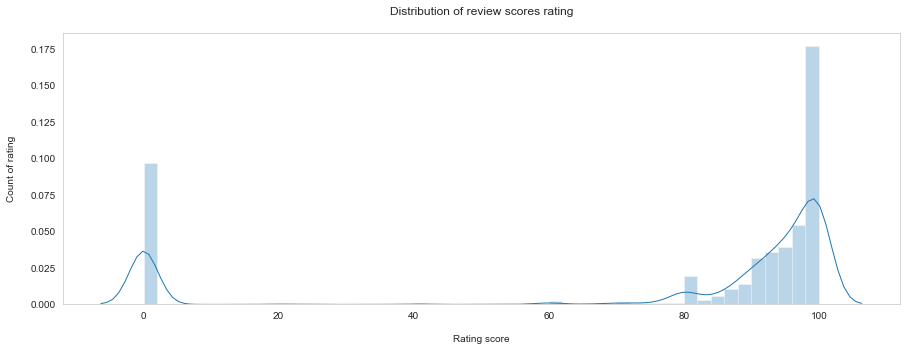

In [200]:
plt.figure(figsize=(15,5))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.distplot(berlin_data.review_scores_rating, 
             kde_kws={'linewidth':1},
             hist_kws={'alpha':.3})
plt.xlabel('\nRating score')
plt.ylabel('Count of rating\n')
plt.title('Distribution of review scores rating\n');


Since our data is significantly negatively skewed lets take the log of the data (without the zero values) and plot it again.



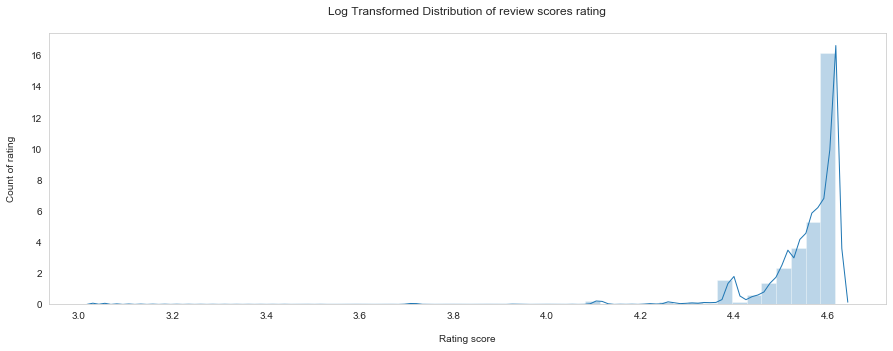

In [202]:
plt.figure(figsize=(15,5))
sns.set_style("whitegrid", {'axes.grid' : False})

# taking log of the data except 0's
sns.distplot(np.log1p(berlin_data.review_scores_rating[berlin_data['review_scores_rating'] > 0]), 
             kde_kws={'linewidth':1},
             hist_kws={'alpha':.3})
plt.xlabel('\nRating score')
plt.ylabel('Count of rating\n')
plt.title('Log Transformed Distribution of review scores rating\n');

 
Log transforming does not help as there are present but very few reviews for the lower ranges.

Assigning a rating '1-5' to each listing based on their review score would have proved counter productive as the distributions above showed most of the listings are present in the upper and hence we would not achieve effective segregation of the listings based on their rating score.

Lets reconsider our strategy and view the data above 75 rating to see its distribution and then make our decision to subset the popular listings.


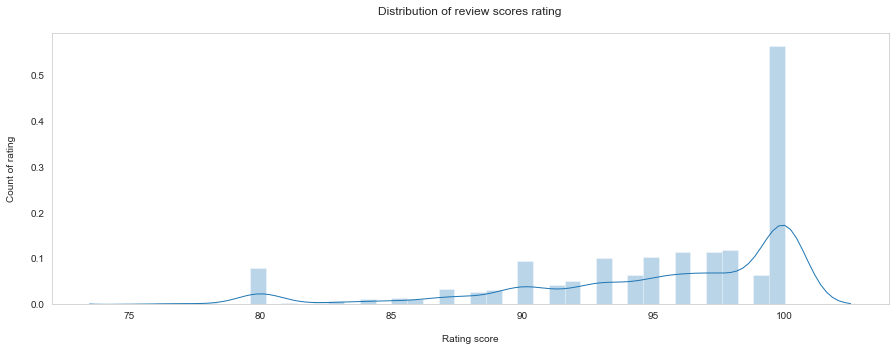

In [63]:
plt.figure(figsize=(15,5))
sns.set_style("whitegrid", {'axes.grid' : False})

sns.distplot(berlin_data.review_scores_rating[berlin_data['review_scores_rating'] > 75], 
             kde_kws={'linewidth':1},
             hist_kws={'alpha':.3})
plt.xlabel('\nRating score')
plt.ylabel('Count of rating\n')
plt.title('Distribution of review scores rating\n');


Seems like most of the listings have scores that are concentrated between '80-100'.

Reconsidering our intital technique we'll select review_scores_ratings having score > 90 as high performing listings for our analysis.




With this we have ironed out our data and can start the analysis. 



# Exploratory Analysis

### Property Types

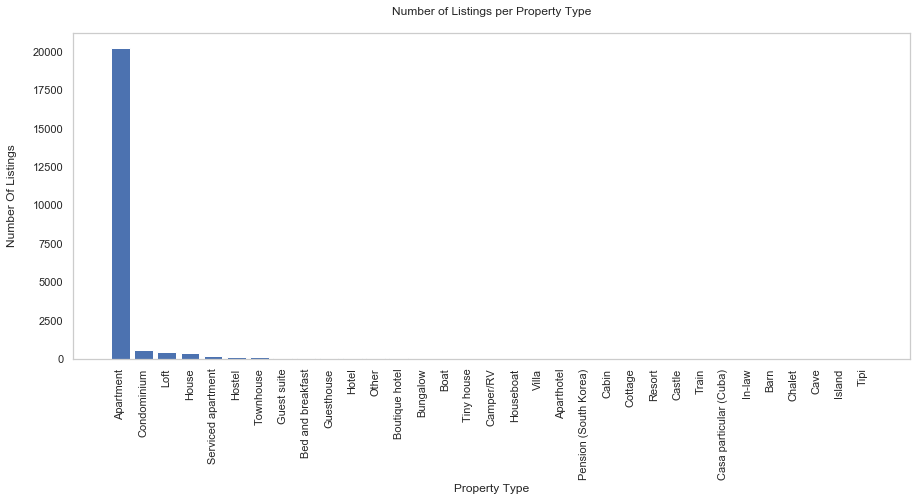

In [178]:
plt.figure(num=1, figsize=(15,6))
sns.set_style("whitegrid", {'axes.grid' : False})
plt.bar(x = berlin_data.property_type.value_counts().index, 
        height = berlin_data.property_type.value_counts().values)
plt.xlabel('Property Type')
plt.ylabel('Number Of Listings\n')
plt.title('Number of Listings per Property Type\n')
plt.xticks(rotation = 90);


Most of the Airbnb listings in Berlin during period our data is gathered are apartment listings with over 20000 of them with very small amounts of Condominiums, Lofts and Houses.


### Room Types

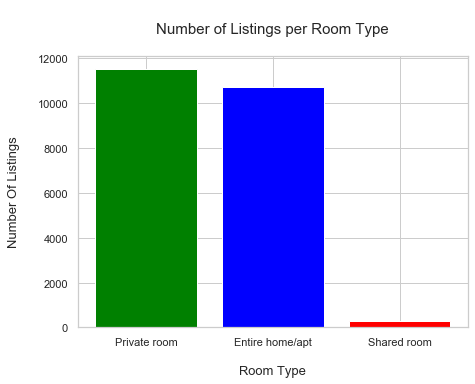

In [173]:
plt.figure(num=2, figsize=(7,5))
plt.bar(x = berlin_data.room_type.value_counts().index, 
        height = berlin_data.room_type.value_counts().values, color=('green','blue','red'))
plt.xlabel('\nRoom Type',fontsize=13)
plt.ylabel('Number Of Listings\n',fontsize=13)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=10)
plt.title('\nNumber of Listings per Room Type\n',fontsize=15);
#plt.xticks(rotation = 90);

In [ ]:

Seems like shared rooms are an unpopular with Airbnb property listers. 

Lets view the composition of the property types shown before for the room types above.


<Figure size 432x288 with 0 Axes>

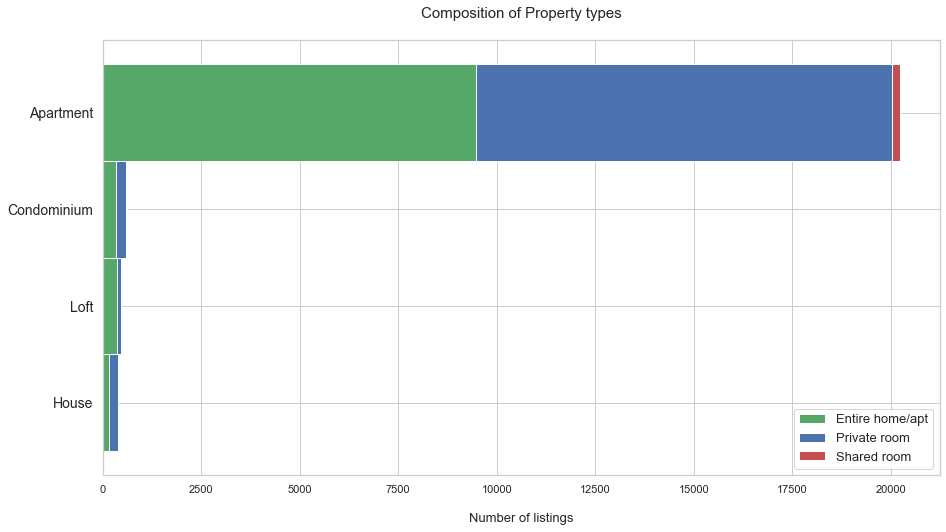

In [338]:
plt.figure(num=3);

prop = berlin_data.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=300]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["g","b","r"], linewidth = 1, grid=True, figsize=(15,8), width=1);
plt.title('Composition of Property types\n', fontsize=15);
plt.xlabel('\nNumber of listings', fontsize=13);
plt.ylabel('');
plt.legend(loc = 4,prop = {"size" : 13});
plt.rc('ytick', labelsize=13);
plt.show();


All shared rooms are within appartments. Probably some room owners looking to share their rooms for extra income.

The Loft Property type is mainly being let out competely as the entire home with a small amount listed having private rooms.

Other Property types are almost equally let out as an entire property or as a Private Room.


### Price range within Berlin

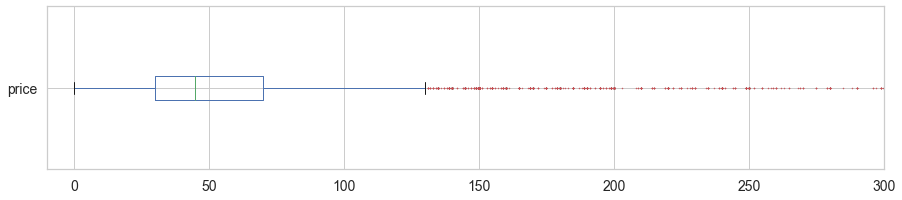

In [168]:
plt.figure(num = 4);
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.', markersize = 1)
berlin_data['price'].plot(kind='box', vert=False, xlim=(-10,300),flierprops=red_square, figsize=(15,3))

plt.rc('xtick', labelsize=11)
plt.show();


The prices have a very broad range as indicated by the outliers above. However we can ascertain that majority of the prices are lesser than $150.


### Price range for each room type

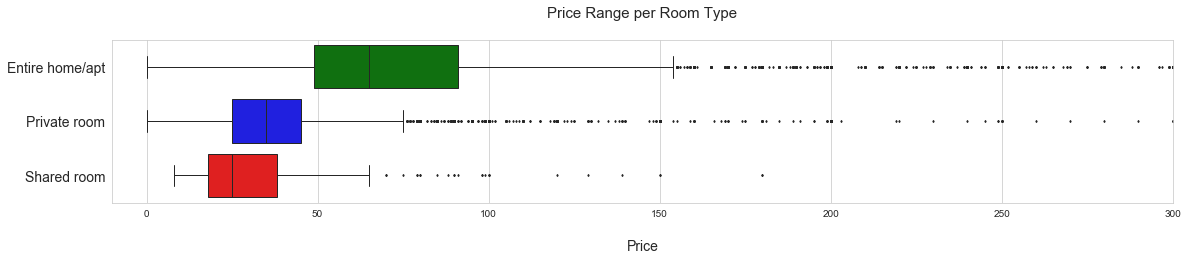

In [208]:
plt.figure(num=5, figsize=(19, 3))
ax = sns.boxplot(x = 'price', y = 'room_type', data = berlin_data, palette = ['g','b','r'], fliersize = 1.5, linewidth=1)
plt.xlim(-10, 300)
plt.title('Price Range per Room Type\n', fontsize=15)
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('')
plt.rc('ytick', labelsize=14)
plt.show();


The room types majorly have prices below $150.

The shared room is expected to have a lower a price range than the other room types which is evident above. However the plotted outliers indicate a few pricey listings as well. These must be rooms that accomodates a larger number of people.


### Geographical overview of listings

In [339]:
berlin_data_sharedRoom = berlin_data.loc[berlin_data['room_type'] == 'Shared room' ,:]
berlin_data_privateRoom = berlin_data.loc[berlin_data['room_type'] == 'Private room',:]
berlin_data_entireHome = berlin_data.loc[berlin_data['room_type'] == 'Entire home/apt',:]

berlin_data_sharedRoom = berlin_data.loc[berlin_data['price'] <= 150 ,:]
berlin_data_privateRoom = berlin_data.loc[berlin_data['price'] <= 150,:]
berlin_data_entireHome = berlin_data.loc[berlin_data['price'] <= 150,:]

In [163]:
# overiview of listings over Berlin map
latitudes = berlin_data['latitude'].tolist()
longitudes = berlin_data['longitude'].tolist()
locations = list(zip(latitudes, longitudes))
map_cluster = folium.Map(location=[52.509, 13.381], zoom_start=11)
FastMarkerCluster = FastMarkerCluster(data=locations).add_to(map_cluster);
map_cluster


Majority of listings located in the South East Region with Central Berlin having the bulk of listings.


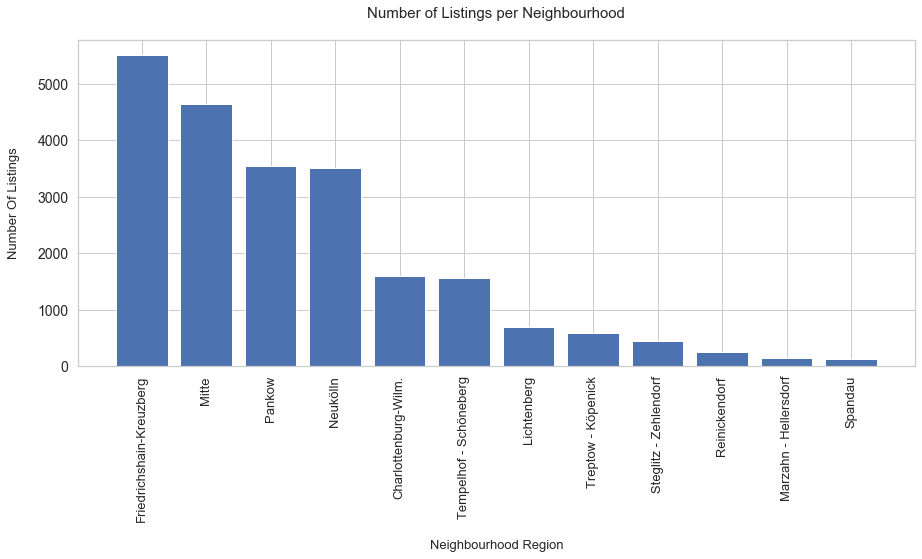

In [166]:
plt.figure(num=6, figsize=(15,6))
plt.bar(x = berlin_data.neighbourhood_group_cleansed.value_counts().index, 
        height = berlin_data.neighbourhood_group_cleansed.value_counts().values)
plt.xlabel('\nNeighbourhood Region',fontsize=13)
plt.ylabel('Number Of Listings\n',fontsize=13)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=11)
plt.title('Number of Listings per Neighbourhood\n',fontsize=15);
plt.xticks(rotation = 90); 

### Price by Neighbourbhood 

<Figure size 432x288 with 0 Axes>

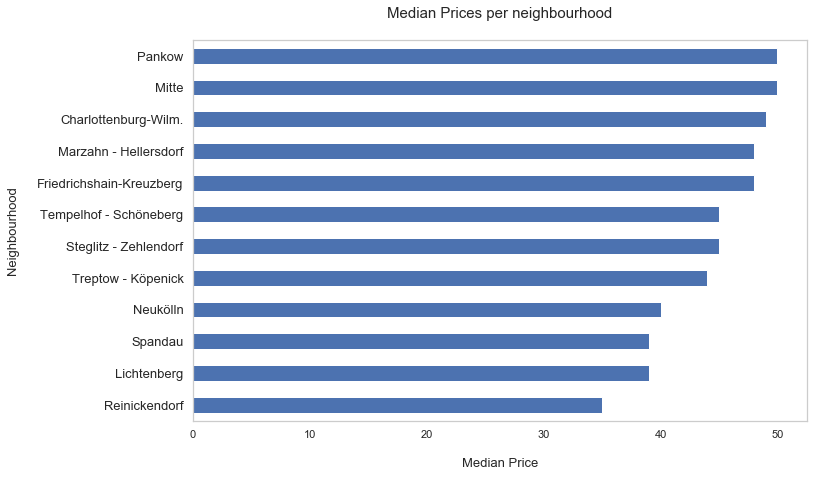

In [339]:
neighbourhood_price = pd.DataFrame(berlin_data.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))
neighbourhood_price.reset_index(inplace=True)

# plot this 
plt.figure(num=7)
neighbourhood_price.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(11,7), legend = False)

plt.xlabel('\nMedian Price', fontsize=13)
plt.ylabel('Neighbourhood\n', fontsize=13)
plt.title('Median Prices per neighbourhood\n', fontsize=15);

### Number of reviews Vs price


Let's examine if we can discover any relations by plotting prices and number of reviews given by customers. 

For this we'll use a scatterplot with near transparent data points. This will allow us to view the concentration of data points by causing more dense regions to stand out.

Each data point is a listing and we can infer the following:
1. An estimate of the quantity of lisitngs for the different price ranges
2. The number of reviews they generally get.
3. The price ranges that attract most reviews and hence are more popular.

We'll limit the observable price range to $300 as most prices fall within this range as observed before and it should include a few outlier cases as well.
 


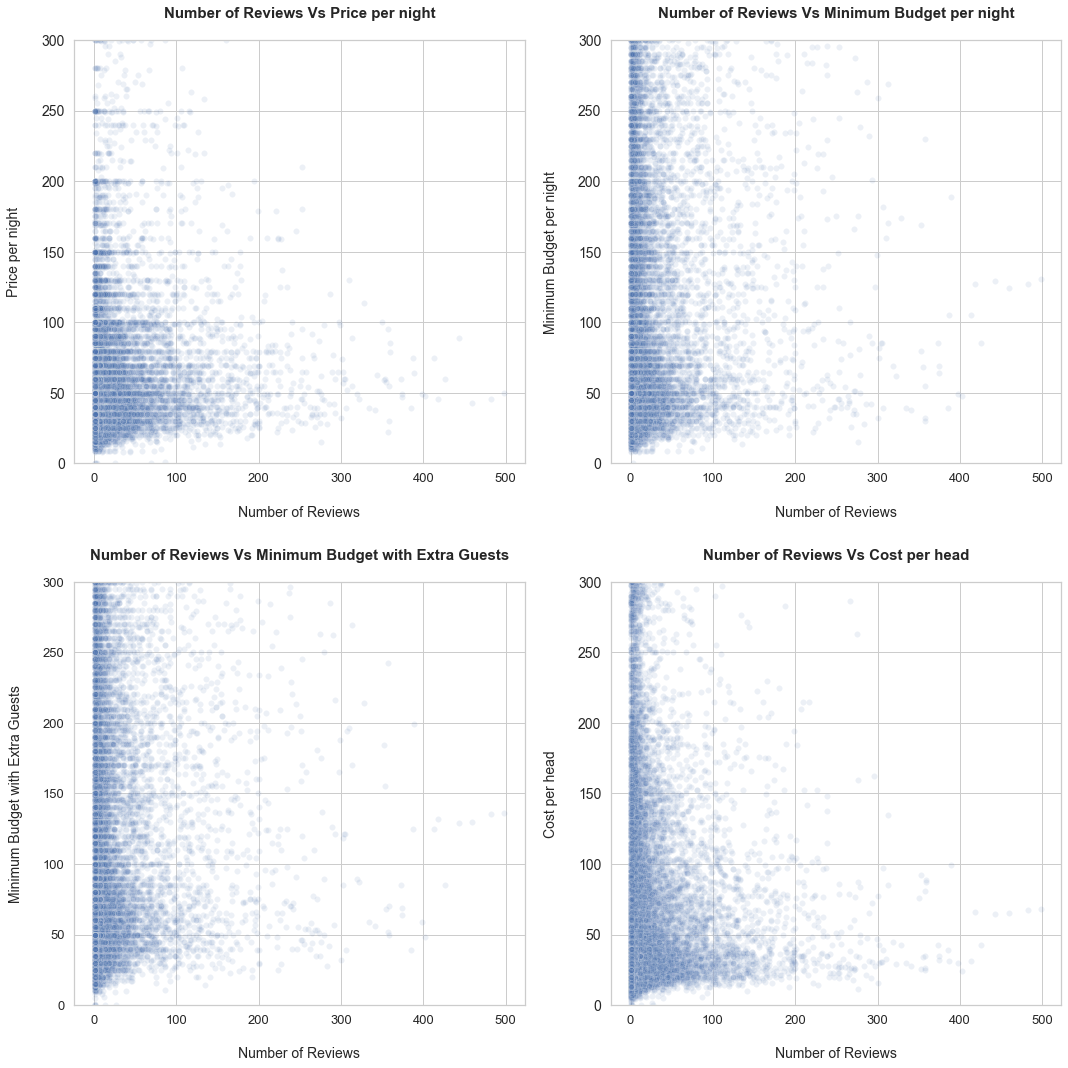

In [165]:
plt.figure(num=8, figsize=(15,15), linewidth=1)

# consider only those data points that have reviews 
berlin_data2 = berlin_data.loc[berlin_data['number_of_reviews'] > 0]

plt.subplot2grid((6, 6), (0, 0),rowspan=3, colspan=3)
ax = sns.scatterplot(x='number_of_reviews', y='price', data=berlin_data2, alpha = 0.1)

plt.title('Number of Reviews Vs Price per night\n', fontsize=15,fontweight = 'bold')
plt.xlabel('\nNumber of Reviews', fontsize=14)
plt.ylabel('Price per night\n',fontsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=13)
plt.ylim(0, 300);


plt.subplot2grid((6, 6), (0, 3),rowspan=3, colspan=3)
ax = sns.scatterplot(x='number_of_reviews', y='minimum_budget', data=berlin_data2,alpha = 0.1)
plt.title('Number of Reviews Vs Minimum Budget per night\n', fontsize=15, fontweight = 'bold')
plt.xlabel('\nNumber of Reviews', fontsize=14)
plt.ylabel('Minimum Budget per night\n',fontsize=14)
plt.rc('ytick', labelsize=13)
plt.rc('xtick', labelsize=13)
plt.ylim(0, 300);


plt.subplot2grid((6, 6), (3, 0),rowspan=3, colspan=3)
ax = sns.scatterplot(x='number_of_reviews', y='minimum_budget_inc_guests', data=berlin_data2,alpha = 0.1)
plt.title('\nNumber of Reviews Vs Minimum Budget with Extra Guests\n', fontsize=15,fontweight = 'bold')
plt.xlabel('\nNumber of Reviews', fontsize=14)
plt.ylabel('Minimum Budget with Extra Guests\n',fontsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=13)
plt.ylim(0, 300);


plt.subplot2grid((6, 6), (3, 3), rowspan=3, colspan=3)
ax = sns.scatterplot(x='number_of_reviews', y='cost_per_head', data=berlin_data2,alpha = 0.1)
plt.title('\nNumber of Reviews Vs Cost per head\n', fontsize=15,fontweight = 'bold')
plt.xlabel('\nNumber of Reviews', fontsize=14)
plt.ylabel('Cost per head\n',fontsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=13)
plt.ylim(0, 300);


plt.tight_layout();


Firstly it seems that the derived columns dont have any significant difference amongst each other and even when compared with the original price column. The only difference between the plots of price and the derived columns is that for the derived column plots the region where Number of reviews < 10 and Price > $150 the derived columns plots have a greater density of lisitngs.

This is because the initial price column is essentially being scaled in our derived columns (through the addition of price values like security deposit, etc). This translates to the 1st plot spreading into the higher price ranges but as it still has the same number of reviews value corresponding to it, this is also spread to the higher price ranges.

So lets consider our initial price column for further analysis as the others dont provide much value. But not discard them as they could be used in further analysis.

What stands out is
1. Price range $10 - $100 has the highest number of listings indicated by the density of data points and they ususally have lesser than 100 reviews.
2. The higher reviews(200-500) also occur for this price range indicating these ranges are popular amongst users.
3. There are a small amount of listings in the price range $100 - $200 but much lesser beyond.


# Analysing high performing listing


To analyse the Airbnb listings in Berlin which have a higher performance we will consider two metrics over which we subset our data

1. The number of reviews
2. The rating score of the listing

which will allow us to reflect upon those listings which attract more visitors and perform well respectively.

From our previous analysis we have identified the upper ranges of these values to be >= 200 and and >=90 respectively.

Lets first see the amount of lisitngs we get using the above as a filter and then judge for further analysis.


In [205]:
# filter for high performing listings
berlin_data_pop = berlin_data.loc[(berlin_data['number_of_reviews'] >= 200) & (berlin_data['review_scores_rating'] >= 90)]

In [211]:
# has 161 listings under our condition
print('\nThe high performing dataframe has {} listings '.format(berlin_data_pop.shape[0]))


The high performing dataframe has 161 listings 


### Count of listings per room type

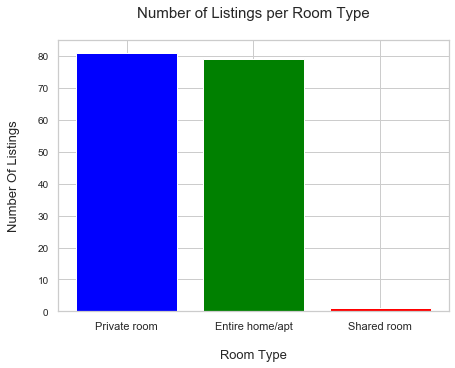

In [175]:
plt.figure(num=9, figsize=(7,5))
plt.bar(x = berlin_data_pop.room_type.value_counts().index, 
        height = berlin_data_pop.room_type.value_counts().values, color=('blue','green','red'))
plt.xlabel('\nRoom Type',fontsize=13)
plt.ylabel('Number Of Listings\n',fontsize=13)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Number of Listings per Room Type\n',fontsize=15);


Seems our previous observation still holds true across the high performing listings, although almost at parity. Shared rooms not among the popular listings with just one listing.


### Price Range for each room type

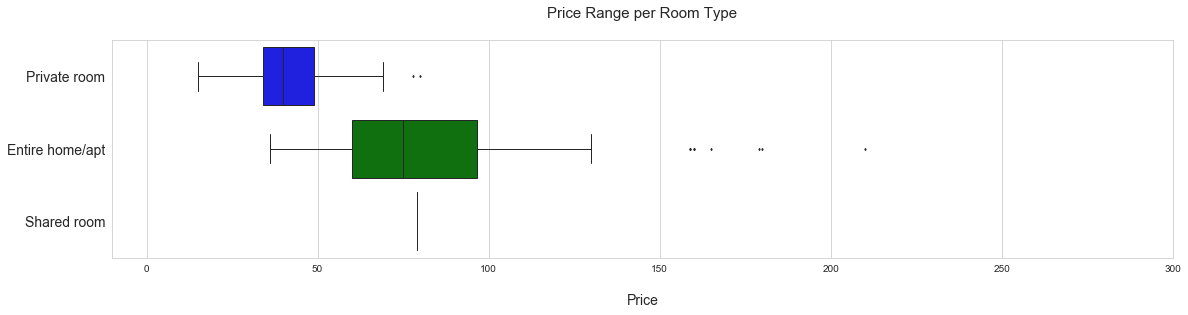

In [210]:
plt.figure(num=10, figsize=(19, 4))
sns.set_style("whitegrid", {'axes.grid' : True})
ax = sns.boxplot(x = 'price', y = 'room_type', data = berlin_data_pop, palette = ['b','g','r'], fliersize = 1.5, linewidth=1)
plt.xlim(-10, 300)
plt.title('Price Range per Room Type\n', fontsize=15)
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('')
plt.rc('ytick', labelsize=14)
plt.show();


We have a single popular listing for shared room having price ~$80. 

The 'Entire Home/Apt.' listings are considerably more expensive. Each room type displays a range of prices for the high performing listings with their distributions slightly skewed to the right indicating the tendency toward lower prices.

The outliers indicate a few listings with prices above $150 per night for the entire home category. These could be premium listings. Although this gives us an overview, we cant conclude anything significant by analysing the prices. If we analyse the prices on a map we could form more relations and derive insights.


## Geographic analysis

### Analysing Room Types Vs location

In [126]:
# base map creation over which we will plot the roomtypes
lat = 52.509
long = 13.381
base2 = folium.Map(location=[lat,long], zoom_start=11.5) 
base2;

In [127]:
# defining colours for the room type markers
def colour(berlin_popular_type):
    if room_type == 'Private room':
        return 'blue'
    elif room_type == 'Entire home/apt':
        return 'green'
    else:
        return'red'
    
# determining the plot points locations and adding to the base map    
berlin_popular_type = folium.map.FeatureGroup();
for lat,long,room_type in zip(berlin_data_pop.longitude, berlin_data_pop.latitude, berlin_data_pop.room_type):
    berlin_popular_type = berlin_popular_type.add_child(
    folium.Circle(
    [long,lat],
    radius = 100,
    color=colour(room_type),
    fill=True,
    fill_color=colour(room_type),
    opacity=0.4,
        fill_opacity = 0.4));
base2.add_child(berlin_popular_type)


There is no discernible difference in the location placement of the different room types.

As indicated by the cluster density it looks like North central Berlin has the majority of our  listings in contrast to the south eastern region as obsereved previously.


### Analysing Price Vs location

In [265]:
# base map for price bins at different locations
lat = 52.509
long = 13.381
base = folium.Map(location=[lat,long], zoom_start=11.5) 
base;

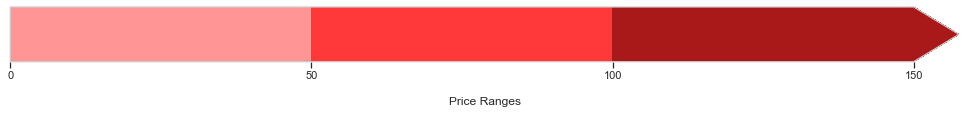

In [282]:
# function to assign a colour to price for its range
def colour(price):
    if (price < 50):
        return '#FF9595'  # light red
    elif (price >=50 and price < 100):
        return '#FF3939'  # red
    else:
        return'#A91919'   # dark red
    
# add the details to the map    
berlin_popular = folium.map.FeatureGroup();
for lat,long,price in zip(berlin_data_pop.longitude, berlin_data_pop.latitude, berlin_data_pop.price):
    berlin_popular = berlin_popular.add_child(
    folium.Circle(
    [long,lat],
    radius = 100,
    color=colour(price),
    fill=True,
    fill_color=colour(price),
    opacity=0.6,
        fill_opacity = 0.6));
    
base.add_child(berlin_popular)

fig, ax = plt.subplots(figsize=(17, 2))
fig.subplots_adjust(bottom=0.5)

# creating the colour bar for price ranges
cmap = mpl.colors.ListedColormap(['#FF9595', '#FF3939', '#A91919'])
bounds = [0,50, 100,150]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                #boundaries=[0] + bounds + [13],
                                extend='max',
                                ticks=bounds,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('\nPrice Ranges')
fig.show()


Using a diverging colour range for the prices we can see that our price ranges aren't confined to certain regions. 

We can observe that the excpetionally higher priced lisitngs tend to be present closer to the center of Berlin with a few cases on the fringes of the city. It is more likely these are premium listings as their locations seem to not play a distinguishing role.

Its difficult to discern any insight from this as the different types of rooms do not have any specific clusters and are almost equally present.


### Cancellation policy

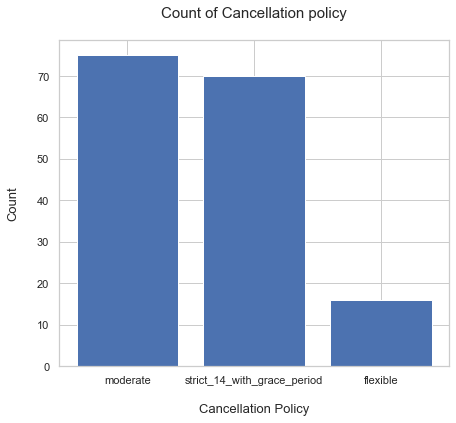

In [159]:
plt.figure(num=11, figsize=(7,6))
plt.bar(x = berlin_data_pop.cancellation_policy.value_counts().index, 
        height = berlin_data_pop.cancellation_policy.value_counts().values)
plt.xlabel('\nCancellation Policy',fontsize=13)
plt.ylabel('Count\n',fontsize=13)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Count of Cancellation policy\n',fontsize=15);


Having a flexible cancellation policy is also not an underlying theme for these listings.


### Review ratings 

In [142]:
# variable to hold column names that we need to analyse
measures = ['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
           'review_scores_location','review_scores_value']

# convert wide data to long format against the above measures
measures_data_tidy = pd.melt(berlin_data_pop, value_vars = measures, var_name='measures', value_name = 'measures_value')

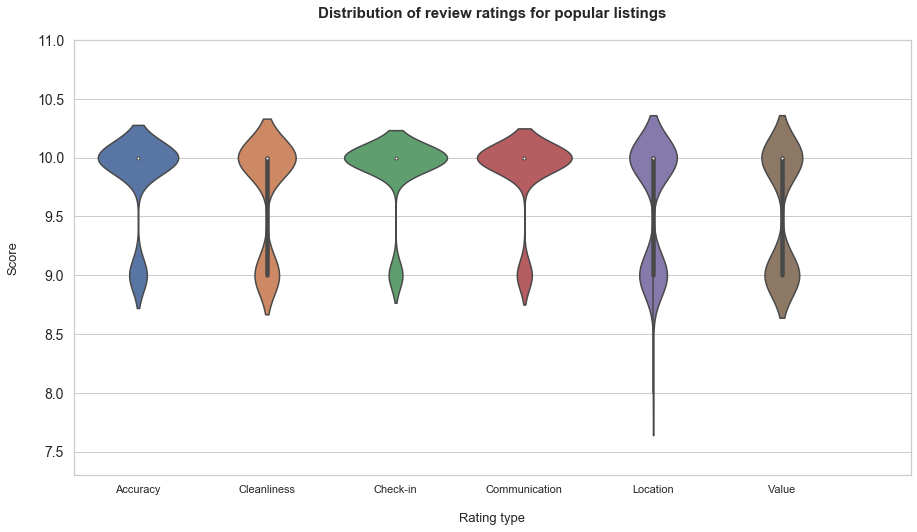

In [241]:
plt.figure(num=12, figsize=(15,8), linewidth=1)

labels = ['Accuracy', 'Cleanliness','Check-in','Communication','Location','Value']

ax = sns.violinplot(x='measures', y='measures_value', data=measures_data_tidy)
plt.title('Distribution of review ratings for popular listings\n', fontweight = 'bold', fontsize=15)
plt.xlabel('\nRating type', fontsize=13)
plt.xticks([0,1,2,3,4,5,6],['Accuracy', 'Cleanliness','Check-in','Communication','Location','Value'])
plt.ylabel('Score\n',fontsize=13)
plt.ylim(7.3, 11);



Looks like it is location and value ratings that guests are more critical of, with ratings for location being the least amongst all ratings going as low as 8. Aditionally, unlike the other categories having majority score of 10, value scores are divide between 10 and 9.


### Correlation Matrix


Lets finally use a correlation matrix to highlight any correltaion amongst our variables if we were unable to identify it through the previous analysis


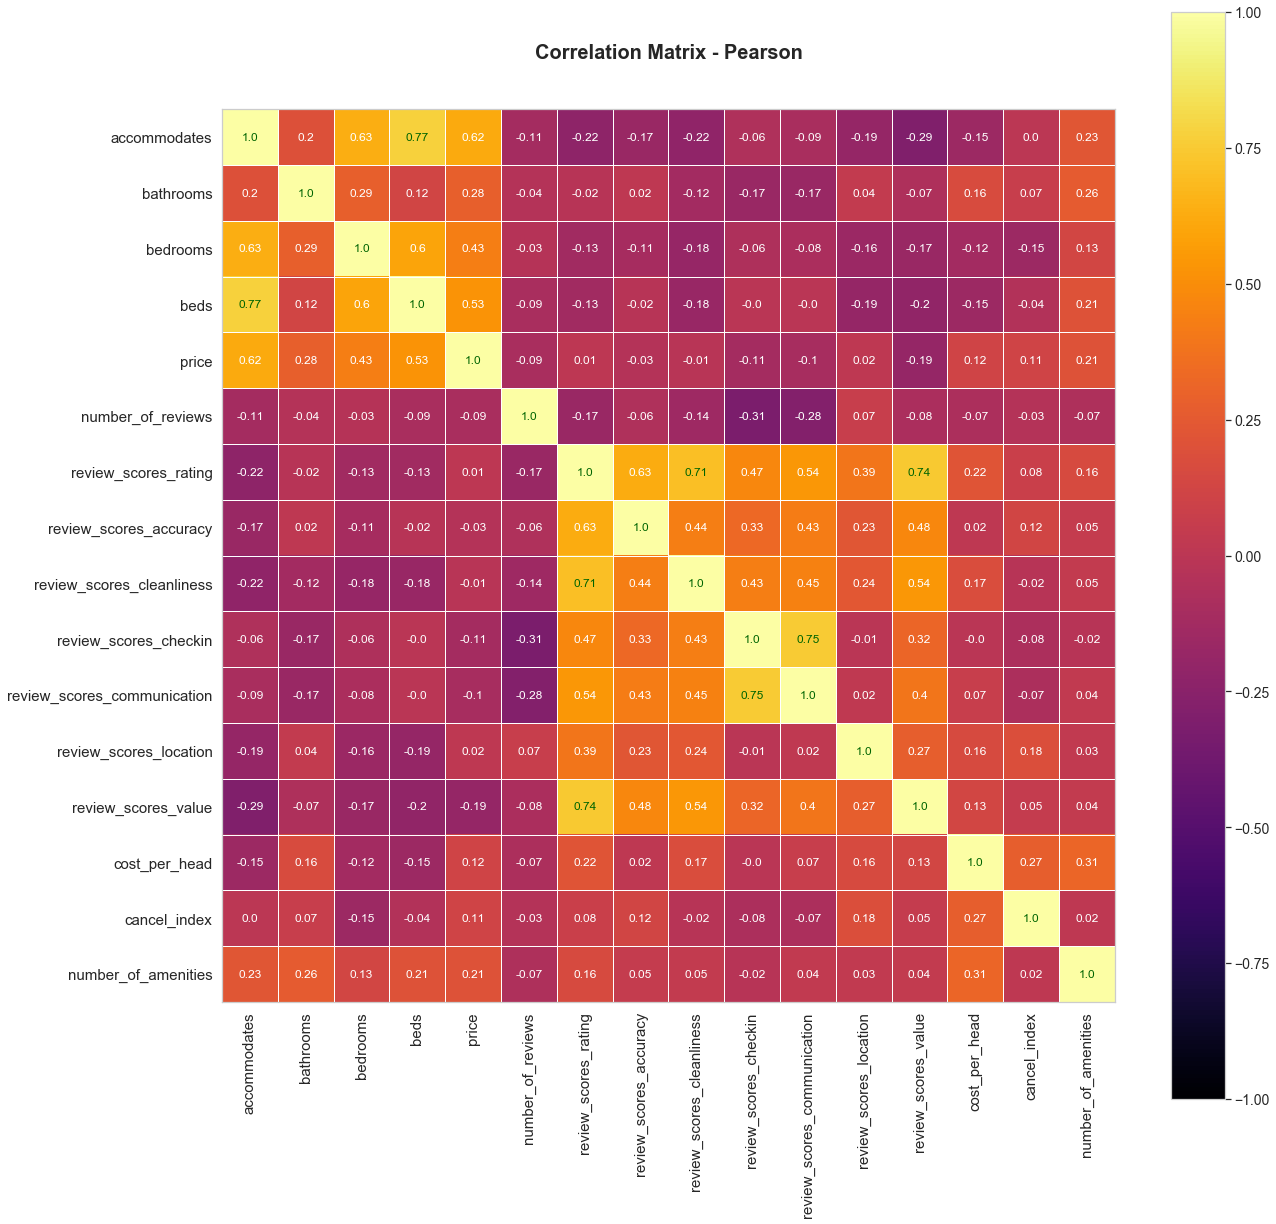

In [273]:
# Correlation Matrix
variables = ['accommodates','bathrooms','bedrooms','beds','price','number_of_reviews','review_scores_rating',
             'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
             'review_scores_location','review_scores_value','cost_per_head','cancel_index','number_of_amenities']

plt.figure(num=13, figsize=(20,20))

corrMat = berlin_data_pop[variables].corr(method='pearson') 
plt.matshow(corrMat, fignum=False, vmin=-1, vmax=1, cmap='inferno')
           
for i in range(len(variables)):
    for j in range(len(variables)):
        if corrMat.iloc[i, j] < 0:
            plt.text(i, j, round(corrMat.iloc[i, j], 2), ha="center", va="center", color="white")
        elif corrMat.iloc[i, j] > 0.7:
            plt.text(i, j, round(corrMat.iloc[i, j], 2), ha="center", va="center", color="darkgreen")
        else:
            plt.text(i, j, round(corrMat.iloc[i, j], 2), ha="center", va="center", color="white")           


plt.xticks(range(len(variables)), variables, rotation=90, fontsize = 15)
plt.yticks(range(len(variables)), variables, fontsize = 15)
plt.tick_params(axis='x', labelbottom=True, labeltop=False, top=False, bottom=False)

ax = plt.gca()
ax.set_xticks(np.arange(len(variables))-.5, minor=True)
ax.set_yticks(np.arange(len(variables))-.5, minor=True)

plt.tick_params(axis='x', which='both', labelbottom=True, labeltop=False, top=False, bottom=False)

plt.grid(which='minor', color='w', linestyle='-', linewidth=1)
plt.grid(False)
plt.title('Correlation Matrix - Pearson', fontsize = 20, fontweight = 'bold')
plt.colorbar();


No significant positive or negative correlation amongst variables apart from 'accommodates' and 'beds'.



From the above carried analysis we've gained an overview, but haven't obtained any solid patterns leading us to draw definite conclusions from the various levels in the data of our high performing listings.

The next approach would be to look at the user reviews to extract and hopefully get a better idea of any underlying themes if any for our poular listings. 

For this lets first use a wordcloud to determine the most frequent words and use then judge the next action.


# User Reviews Analysis

### Load the Data

In [40]:
# load the reviews data
reviews = pd.read_csv('/.../berlin_reviews_summary.csv')

### Filter high performing listings

In [41]:
# create an empty list to store the listing ids that have been determined as high performing previously
pop_id = []
pop_id = berlin_data_pop.id

In [42]:
# use the id list to filter reviews 
reviews_pop = reviews[reviews.listing_id.isin(pop_id)]

In [43]:
# 43053 reviews to extract from
reviews_pop

,listing_id,id,date,reviewer_id,reviewer_name,comments
566,17409,113578,2010-10-07,227967,Jonas,"Nice apartment and location, good room, and gr..."
567,17409,163658,2011-01-03,289562,Matthieu,"Ideal location, in a great neighborhood, with ..."
568,17409,1350474,2012-05-26,2064830,Jonathan,I stayed here for 37 nights and would very gla...
569,17409,1376775,2012-05-29,12602,Nathan,"Wolfram was a fantastic host-- helpful, attent..."
570,17409,1421239,2012-06-05,2278460,Sergio,Wolfram es muy amable y dispuesto. Fue muy int...
...,...,...,...,...,...,...
267673,14582783,338303001,2018-10-19,21624001,Douglas,Alex's place is probably the best airbnb that ...
267674,14582783,338761067,2018-10-20,220790851,Norbert,Tolle unkomplizierte Übernachtung. Netter Empf...
267675,14582783,340222376,2018-10-23,51792659,Luisa,Cameretta piccola ma dotata di tutti i comfort...
267676,14582783,343644692,2018-11-01,102743631,Sarah,Alex is a great host. When our arrival time ch...


### Word Cloud

In [44]:
# create a function to detect the language used for the review. we need only English reviews

def language(comment):
    review = str(comment)
    try: 
            return detect(review) 
    except : 
            return 'Unknown Language'

In [45]:
# iterate through each review in the comments column and determine the language using function defined previously
for index, row in reviews_pop.iterrows():
    lang_used = language(row['comments'])
    reviews_pop = reviews_pop.set_value(index, 'language', lang_used);

In [46]:
# consider only english reviews
reviews_en = reviews_pop.loc[reviews_pop['language']=='en']

In [47]:
# verify the language column (30482 reviews to use)
reviews_en.language.unique()

reviews_en

array(['en'], dtype=object)

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
566,17409,113578,2010-10-07,227967,Jonas,"Nice apartment and location, good room, and gr...",en
567,17409,163658,2011-01-03,289562,Matthieu,"Ideal location, in a great neighborhood, with ...",en
568,17409,1350474,2012-05-26,2064830,Jonathan,I stayed here for 37 nights and would very gla...,en
569,17409,1376775,2012-05-29,12602,Nathan,"Wolfram was a fantastic host-- helpful, attent...",en
571,17409,2170680,2012-09-02,3003307,Paulina,Wolfram was a very good host and really consid...,en
...,...,...,...,...,...,...,...
267670,14582783,333520936,2018-10-07,134497340,Von Ryan,best host besr place.. and worth the money!,en
267671,14582783,335078050,2018-10-11,128472072,Caroline,A great place in Berlin. Quiet and comfortable...,en
267672,14582783,337483377,2018-10-16,103516162,Raul,Alex was patient through our slight travel del...,en
267673,14582783,338303001,2018-10-19,21624001,Douglas,Alex's place is probably the best airbnb that ...,en


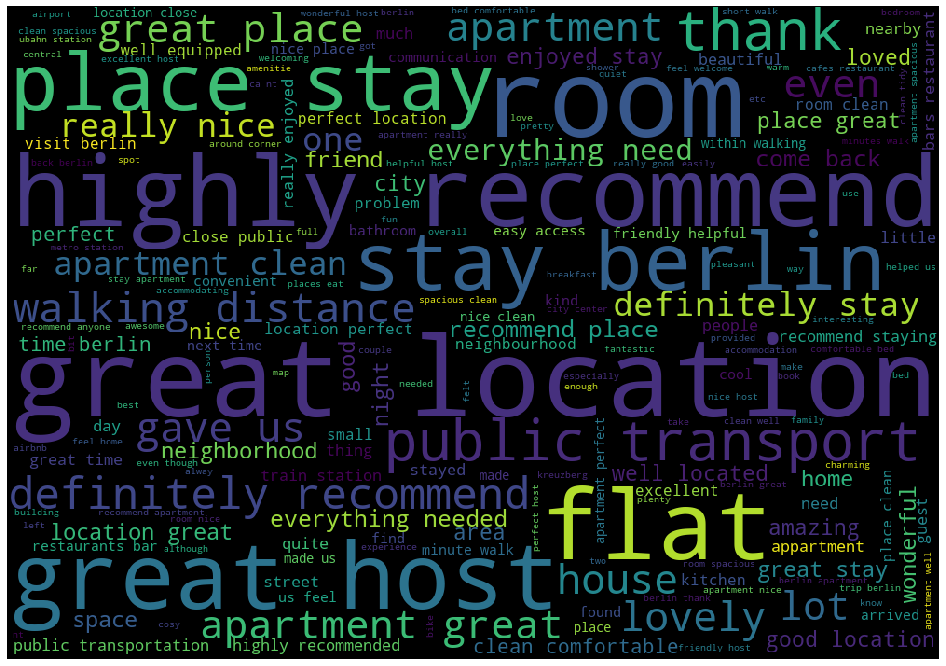

In [274]:
# create an empty string to contain all our words
words = ''

for index,row in reviews_en.iterrows():
    words += row['comments']

# split above words string into substrings for further processing  
reviews_data = nltk.word_tokenize(words)

# create variable to filter common punctuations
punctuation = string.punctuation

# create variable to filter out the below characters and numbers
char = ['\r','\n','',' ','!',',']
numbers = ['0','1','2','3','4','5','6','7','8','9']

# create variable to filter out common english stop words which have a high frequency and may affect our word cloud
StopWords = stopwords.words('english')

# get the list of words only
words_filtered = [''.join(word for word in substr if word not in (punctuation or numbers or char)) for substr in reviews_data]
words_filtered = [substr for substr in words_filtered if substr]
comments_filtered = ' '.join(words_filtered)
comments_filtered = ' '.join([word.lower() for word in comments_filtered.split() if word not in StopWords])


wordcloud = WordCloud(width = 1000, height = 700).generate(comments_filtered);
plt.figure(num=14, figsize=(18,12));
plt.imshow(wordcloud);
plt.axis('off');
plt.show();


The word cloud allows us to see the most frequent used words in the reviews. For the high performing listings the following factors seem dominant
1. Location of the listing
2. Host of the listing
3. Surrounding resources like public transport, Restaurants
4. Cleanliness
5. Type of listing (apartment, flat)
6. It also shows a conveyance of emotion from the guests(lovely, enjoyed, thank, highly recommend, feel)

Now that we ave some idea of the reviews, lets try to extract topics from the reviews using topic modelling through Non Negative Matrix factorization using TFIDF.
To run the model we need to first clean our data and get it in an efficient format before passing to the necessary functions for further use.

### Topic Modelling

In [340]:
# cleaning the reviews data

# create a column for the clean values
reviews_en['comments_filtered'] = reviews_en['comments']
    
# remove Punctuation
reviews_en['comments_filtered'] = reviews_en['comments_filtered'].apply(lambda string: ' '.join([word for word in string.split() if word not in (punctuation or numbers or char)]))

# remove the stopwords defined earlier and convert the words to lowercase
reviews_en['comments_filtered'] = reviews_en['comments_filtered'].apply(lambda string: ' '.join([word.lower() for word in string.split() if word not in StopWords]))

# remove all other substrings apart from words                                                                     
reviews_en['comments_filtered'] = reviews_en['comments_filtered'].apply(lambda string: ' '.join([word for word in string.split() if word.isalpha()]))                                                                        
                              
# lemmatize to extract base words to account for the same meaning of different words used in the reviews                                                                        
Lemmatizer = WordNetLemmatizer()
reviews_en['comments_filtered'] = reviews_en['comments_filtered'].apply(lambda string: ' '.join([Lemmatizer.lemmatize(word) for word in string.split()]))

In [346]:
# max number of Words in Vocabulary
max_words = 2000

# create TF-IDF Vectorizer
tfidfVect = TfidfVectorizer(max_features=max_words, stop_words='english');

# tokenize, build vocab encode corpus
tf = tfidfVect.fit_transform(reviews_en['comments_filtered'])

# get features
tfidf_feature_names = tfidfVect.get_feature_names()

In [351]:
# assign the hyperparameter
numberTopics = 6

# run the model
nmf = NMF(n_components=numberTopics, beta_loss='kullback-leibler', solver='mu', max_iter=100, 
          alpha=.1, l1_ratio=.5, init='nndsvd').fit(tf)

In [352]:
# function to display the top words
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [353]:
# display the topics with words
numberTopWords = 25

print_top_words(nmf, tfidf_feature_names, numberTopWords)

Topic #0: stay recommend apartment perfect definitely berlin close place clean highly flat easy located beautiful wonderful time host helpful lot super staying room area loved like
Topic #1: great location highly lovely fantastic martin awesome recommendation accommodating value stylish robert responsive damian base verda marius sight hospitality brilliant load roi fabulous hospitable prompt
Topic #2: nice clean room friendly good host location appartment great near cosy cozy house guy appartement calm rafael wa owner helpfull cat carsten marco recomend kerstin
Topic #3: apartment easy location close good restaurant clean spacious public walk excellent minute quiet comfortable lot transport communication bar walking station area near kitchen bed room
Topic #4: place good stay location berlin frank best public visit near comfortable amazing eat communication value convenient want transport stayed looking kind tip gave quiet city
Topic #5: really room host enjoyed lovely time flat thank 


No clear distinction between the topics excpet that a few correspond to the important themes we previously identified such as 

1. Response to the hosts
3. Transport and surrounding resources
5. Emotion

Maybe using a different technique might provide favourable results.